## Setup
This notebook requires some packages besides pytorch-lightning.

In [ ]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 17.4 MB/s eta 0:00:00


In [ ]:
# Run this if you intend to use TPUs
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

### CIFAR10 Data Module

Import the existing data module from `bolts` and modify the train and test transforms.

In [ ]:

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model

In [ ]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.01, drop= 0.2, norm='BN',groupsize=1):
        super().__init__()

        self.save_hyperparameters()
        self.num_classes =10
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,64,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop))
        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels = 128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,128,groupsize),
            nn.Dropout(drop)
             )

        # CONVOLUTION BLOCK 2
      	# Layer 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,256,groupsize),
            nn.Dropout(drop),
	        nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,256,groupsize),
            nn.Dropout(drop)

             )

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
	        nn.MaxPool2d(2,2),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop)
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.user_norm(norm,512,groupsize),
            nn.Dropout(drop))

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), padding=0, bias=False))
        self.model = nn.Sequential(self.convblock1 ,self.convblock2, self.convblock3, self.convblock4)

    def user_norm(self, norm, channels,groupsize=1):
        if norm == 'BN':
            return nn.BatchNorm2d(channels)
        elif norm == 'LN':
            return nn.GroupNorm(1,channels) #(equivalent with LayerNorm)
        elif norm == 'GN':
            return nn.GroupNorm(groupsize,channels) #groups=2

    def forward(self, x):

        x = self.convblock1(x)
        x = x + self.res1 (x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = x + self.res2 (x)
        x = self.convblock4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
        #out = self.model(x)
        #return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task =  'multiclass', num_classes = self.num_classes)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,

            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.01,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [ ]:
model = LitResnet(lr=0.01)

trainer = Trainer(
    max_epochs=24,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170498071/170498071 [00:21<00:00, 7805429.81it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | convblock1 | Sequential | 75.8 K
1 | res1       | Sequential | 295 K 
2 | convblock2 | Sequential | 295 K 
3 | convblock3 | Sequential | 1.2 M 
4 | res2       | Sequential | 4.7 M 
5 | convblock4 | Sequential | 5.1 K 
6 | model      | Sequential | 1.6 M 
------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.295    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9035999774932861     │
│         test_loss         │    0.28470367193222046    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.28470367193222046, 'test_acc': 0.9035999774932861}]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lr-Adam,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.000545,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.499907,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.703463,0.4347,NaN,NaN
NaN,0.000981,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.395144,NaN,NaN,NaN,NaN


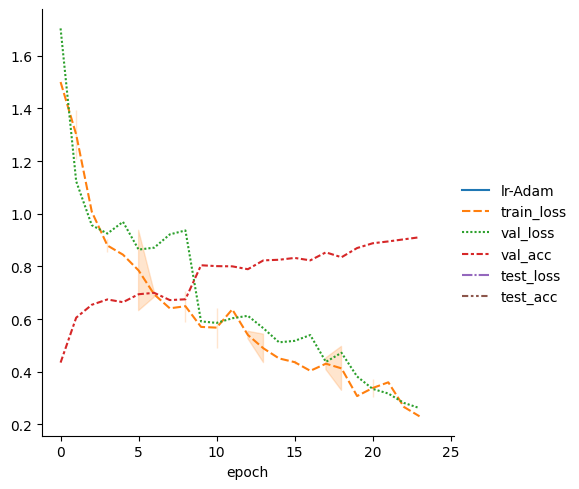

In [ ]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [ ]:
torch.save(model.state_dict(), "model.pth",_use_new_zipfile_serialization=False)

# Getting Misclassified Images

In [ ]:
from matplotlib import pyplot as plt
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1)
            for image, target, pred in zip(data, target, pred):
                if pred.eq(target.view_as(pred)).item() == False:
                    incorrect.append([image.cpu(), target.cpu(), pred.cpu()])

    return incorrect

def display_incorrect_images(mismatch, n=20 ):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    display_images = mismatch[:n]
    index = 0
    fig = plt.figure(figsize=(10,5))
    for img in display_images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = classes[img[2]]
        actual = classes[img[1]]
        ax = fig.add_subplot(2, 5, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10)
        ax.imshow(np.transpose(image, (1, 2, 0)))
        index = index + 1
    plt.show()

In [ ]:
model = LitResnet(lr=.01)
model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

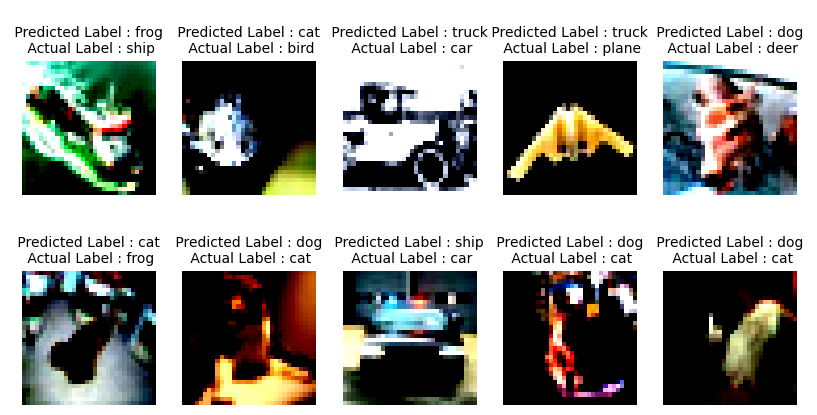

In [ ]:
import numpy as np
mis_class_images = get_incorrrect_predictions(model, cifar10_dm.test_dataloader(), 'cpu')
display_incorrect_images(mis_class_images, n=10)